## Курсовой проект для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

Материалы к проекту (файлы):
train.csv
test.csv

### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

### Целевая переменная:
Price

### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Требования к решению:
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv (пример SShirkin_predictions.csv).
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

Импортируем основные библиотеки:

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error as mae
# from sklearn.model_selection import KFold, GridSearchCV

In [86]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [87]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

Создадим датафрейм из тренировочного датасета и посмотрим на первые 5 его строк:

In [88]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
df_train.head()

DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                   
14038          35   2.00   47.98       29.44           6.00      7   
15053          41   3.00   65.68       40.05           8.00      7   
4765           53   2.00   44.95       29.20           0.00      8   
5809           58   2.00   53.35       52.73           9.00      8   
10783          99   1.00   39.65       23.78           7.00     11   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
14038        9.00       1969       0.09         B         B        33   
15053        9.00       1978       0.00         B         B        46   
4765        12.00       1968       0.05         B         B        34   
5809        17.00       1977       0.44         B         B        23   
10783       12.00       1976       0.01         B         B        35   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
Id                                                                      
14038      7976         5           nan            0       11       B   
15053     10309         1        240.00            1       16       B   
4765       7759         0        229.00            1        3       B   
5809       5735         3      1,084.00            0        5       B   
10783      5776         1      2,078.00            2        4       B   

           Price  
Id                
14038 184,966.93  
15053 300,009.45  
4765  220,925.91  
5809  175,616.23  
10783 150,226.53

Аналогично создадим датафрейм из тестового датасета:

In [89]:
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
df_test.head()

DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                   
725            58   2.00   49.88       33.43           6.00      6   
15856          74   2.00   69.26         nan           1.00      6   
5480          190   1.00   13.60       15.95          12.00      2   
15664          47   2.00   73.05       51.94           9.00     22   
14275          27   1.00   47.53       43.39           1.00     17   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
725         14.00       1972       0.31         B         B        11   
15856        1.00       1977       0.08         B         B         6   
5480         5.00       1909       0.00         B         B        30   
15664       22.00       2007       0.10         B         B        23   
14275       17.00       2017       0.07         B         B         2   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
Id                                                                     
725        2748         1           nan            0        0       B  
15856      1437         3           nan            0        2       B  
5480       7538        87      4,702.00            5        5       B  
15664      4583         3           nan            3        3       B  
14275       629         1           nan            0        0       A

In [90]:
df_train.shape, df_test.shape

((10000, 19), (5000, 18))

### Обработка пропусков

In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.5+ MB


Видим, что есть пропущенные значения у признаков LifeSquare и Healthcare_1.
Обработаем пропуски.

Поскольку в признаке **Healthcare_1** почти половина значений потеряны, принято волевое решение этот признак удалить, как не значимый

In [92]:
df_train.drop(['Healthcare_1'], axis=1, inplace=True)
df_test.drop(['Healthcare_1'], axis=1, inplace=True)

Заменим пропуски в **LifeSquare** на разницу между **Square** и **KitchenSquare**

In [93]:
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = \
    df_train['Square'] - df_train['KitchenSquare']
df_test.loc[df_test['LifeSquare'].isna(), 'LifeSquare'] = \
    df_test['Square'] - df_test['KitchenSquare']

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 1.8+ MB


Видим, что теперь пропусков в данных нет.

#### Категориальные признаки

**DistrictId** (как идентификационный номер района) - явно категория, поэтому меняем тип на строковый

In [94]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

Посмотрим на распределение переменной **Ecology_2**

In [95]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

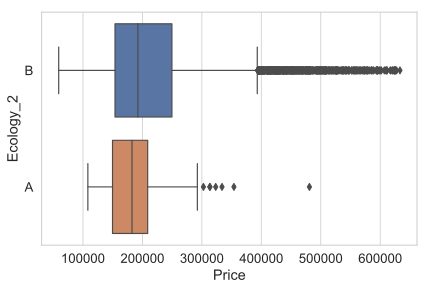

In [96]:
sns.boxplot('Price', 'Ecology_2', data=df_train);

In [97]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [98]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Произведем замену букв на цифры для удобства

In [99]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

df_train[feature_bin_names] = df_train[feature_bin_names].replace({'A':0, 'B':1})
df_test[feature_bin_names] = df_test[feature_bin_names].replace({'A':0, 'B':1})

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
DistrictId       10000 non-null object
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
Price            10000 non-null float64
dtypes: float64(7), int64(10), object(1)
memory usage: 1.8+ MB


#### Количественные переменные

Разберемся с числовыми переменными: уберем целевую переменную и оставим переменные с float64 и int64:

In [100]:
feature_num_names = df_train.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

Посмотрим на гистограммы этих признаков

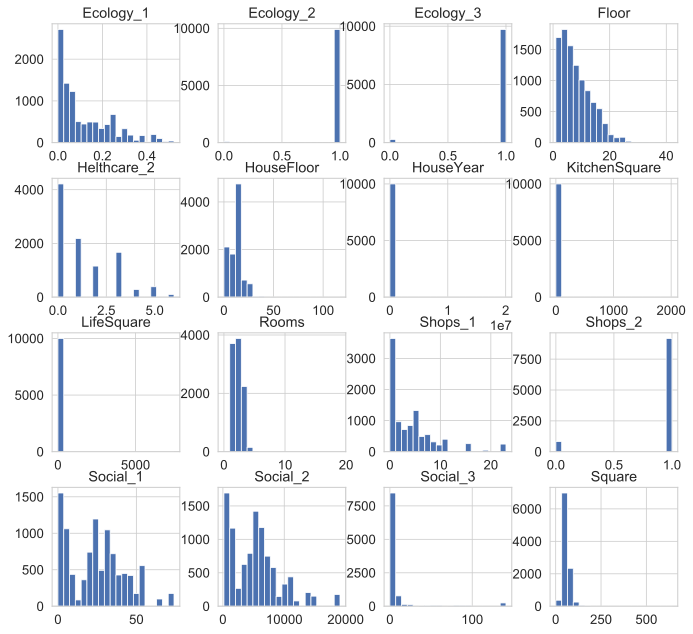

In [101]:
df_train[feature_num_names].hist(figsize=(10,10), bins=20, grid=True);

### Обработка выбросов и ошибок в данных

##### Избавимся от выбросов в **HouseYear**

In [102]:
df_train.loc[(df_train['HouseYear'] > 2020) | (df_train['HouseYear'] < 1915)]

DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
Id                                                                              
6751         172   2.00   56.17       28.38           7.00      8        6.00   
10814        109   1.00   37.27       20.24           9.00      9       12.00   
14556        183   4.00  151.15       98.19          23.00      6        7.00   
11607        147   2.00   44.79       28.36           5.00      4        9.00   
2085         161   1.00   63.29       29.39          18.00      3        9.00   
13288        161   1.00   50.81       15.92          20.00      8        9.00   

       HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
Id                                                                      
6751        1914       0.00          1          1         7      1660   
10814   20052011       0.14          1          1        30      6141   
14556       1912       0.04          1          1        32      6748   
11607       4968       0.32          1          1        25      4756   
2085        1912       0.01          1          1        19      3806   
13288       1910       0.01          1          1        19      3806   

       Social_3  Helthcare_2  Shops_1  Shops_2      Price  
Id                                                         
6751         39            1        5        1 423,580.48  
10814        10            3        6        1 254,084.53  
14556        93            4       10        1 284,884.96  
11607        16            5        8        1 243,028.60  
2085          4            0        3        1 262,279.81  
13288         4            0        3        1 287,954.72

Дома 1910 года еще могут быть, а вот новее 2020 года - вряд ли. Полагая, что значение "20052011" означает дату "20.05.2011", произведем замену на год из этой даты - 2011.

In [103]:
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2011
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Выбросы в Rooms

In [104]:
df_train['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

Полагая значения **Rooms**, равные 0 и превышающие 6, ошибками, избавимся от них:

In [105]:
df_train['Rooms'].mode()[0]

2.0

In [106]:
df_train.loc[(df_train['Rooms'] > 6)|(df_train['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].mode()[0]
df_test.loc[(df_test['Rooms'] > 6)|(df_test['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].mode()[0]

#### Выбросы в Square, LifeSquare, KitchenSquare

In [107]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

Square  LifeSquare  KitchenSquare
count 10,000.00   10,000.00      10,000.00
mean      56.32       41.80           6.27
std       21.06       77.82          28.56
min        1.14        0.37           0.00
25%       41.77       25.49           1.00
50%       52.51       37.04           6.00
75%       65.90       49.82           9.00
max      641.07    7,480.59       2,014.00

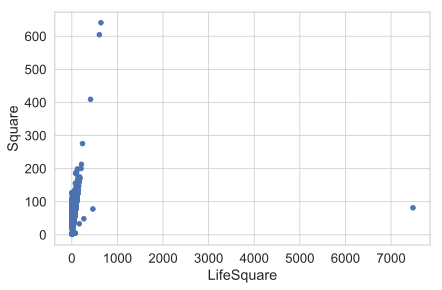

In [108]:
plt.scatter(df_train['LifeSquare'], df_train['Square']);    
plt.xlabel('LifeSquare')
plt.ylabel('Square')
plt.show()     

Видим явные выбросы в **LifeSquare**. Избавимся от них.

In [109]:
df_train.loc[(df_train['LifeSquare'] > 400) | \
             (df_train['LifeSquare'] > df_train['Square']), :].describe()

Rooms  Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
count 484.00  484.00      484.00         484.00 484.00      484.00     484.00   
mean    1.77   61.06       79.81           3.77   9.88       13.72   1,999.73   
std     0.81   46.51      340.87           8.84   6.25        9.90      19.73   
min     1.00    1.14        2.64           0.00   1.00        0.00   1,958.00   
25%     1.00   40.82       42.25           1.00   4.00        6.00   1,977.00   
50%     2.00   53.93       56.20           1.00   9.00       17.00   2,015.00   
75%     2.00   71.81       74.24           5.00  14.00       17.00   2,017.00   
max     4.00  641.07    7,480.59         123.00  28.00      117.00   2,020.00   

       Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  \
count     484.00     484.00     484.00    484.00    484.00    484.00   
mean        0.10       1.00       0.99     14.84  3,416.37      9.53   
std         0.11       0.00       0.08     16.42  3,775.50     31.33   
min         0.00       1.00       0.00      0.00    168.00      0.00   
25%         0.01       1.00       1.00      2.00    629.00      0.00   
50%         0.07       1.00       1.00      6.00  1,564.00      1.00   
75%         0.20       1.00       1.00     24.00  5,735.00      3.00   
max         0.49       1.00       1.00     74.00 19,083.00    141.00   

       Helthcare_2  Shops_1  Shops_2      Price  
count       484.00   484.00   484.00     484.00  
mean          0.87     3.54     0.88 199,831.39  
std           1.40     5.50     0.33  98,523.21  
min           0.00     0.00     0.00  66,630.74  
25%           0.00     0.00     1.00 133,445.72  
50%           0.00     1.00     1.00 177,867.26  
75%           2.00     5.00     1.00 233,743.47  
max           6.00    23.00     1.00 621,002.91

In [110]:
df_train.loc[(df_train['LifeSquare'] > 400) | \
             (df_train['LifeSquare'] > df_train['Square']), 'LifeSquare'] = \
        df_train['LifeSquare'].median()
df_test.loc[(df_test['LifeSquare'] > 400) | \
            (df_test['LifeSquare'] > df_test['Square']), 'LifeSquare'] = \
        df_train['LifeSquare'].median()

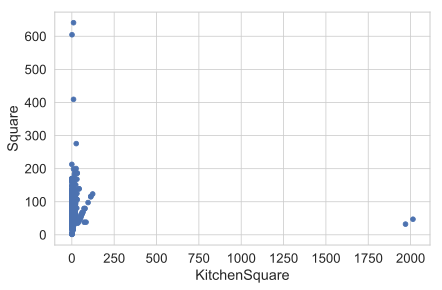

In [111]:
plt.scatter(df_train['KitchenSquare'], df_train['Square']);    
plt.xlabel('KitchenSquare')
plt.ylabel('Square')
plt.show()  

Видим выбросы в **KitchenSquare**. Избавимся от них.

In [112]:
df_train.loc[(df_train['KitchenSquare'] > 150) | \
             (df_train['KitchenSquare'] > df_train['Square']), :]

DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
Id                                                                              
14656         62   1.00   47.10       46.45       2,014.00      4        1.00   
13703         42   1.00   38.07       19.72          73.00      9       10.00   
6569          27   1.00   38.22       18.72          84.00      4       17.00   
14679         81   1.00   32.28       19.28       1,970.00      6        1.00   

       HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
Id                                                                      
14656       2014       0.07          1          1         2       629   
13703       2006       0.16          1          1        21      5731   
6569        2018       0.01          1          1         4       915   
14679       1977       0.01          1          1        30      5285   

       Social_3  Helthcare_2  Shops_1  Shops_2      Price  
Id                                                         
14656         1            0        0        0 108,337.48  
13703         0            1        0        1 160,488.03  
6569          0            0        0        1  99,079.96  
14679         0            6        6        1 105,539.56

In [113]:
df_train.loc[(df_train['KitchenSquare'] > 150) | \
             (df_train['KitchenSquare'] > df_train['Square']),
             'KitchenSquare'] = df_train['KitchenSquare'].median()

df_test.loc[(df_test['KitchenSquare'] > 150) | \
            (df_test['KitchenSquare'] > df_test['Square']),
            'KitchenSquare'] = df_train['KitchenSquare'].median()

На графиках выше были видны и выбросы в **Square**. Избавимся и от них.

In [114]:
df_train.loc[(df_train['Square'] > 400) | (df_train['Square'] < 10), 'Square'] = \
            df_train['Square'].median()

df_test.loc[(df_test['Square'] > 400) | (df_test['Square'] < 10), 'Square'] = \
            df_train['Square'].median()

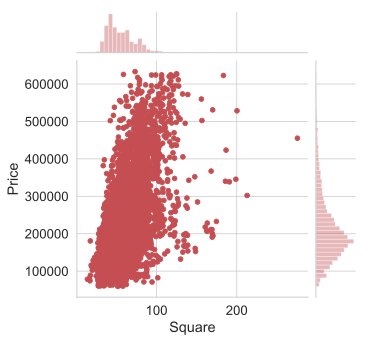

In [115]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=5, color='r');

Посмотрим еще раз на зависимости между **Square**, **LifeSquare** и **KitchenSquare**:

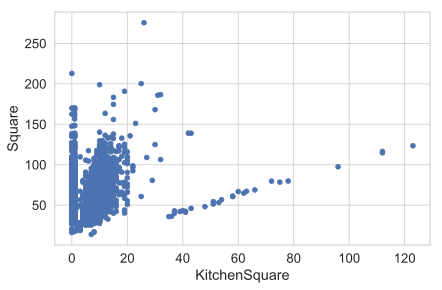

In [116]:
plt.scatter(df_train['KitchenSquare'], df_train['Square']);    
plt.xlabel('KitchenSquare')
plt.ylabel('Square')
plt.show() 

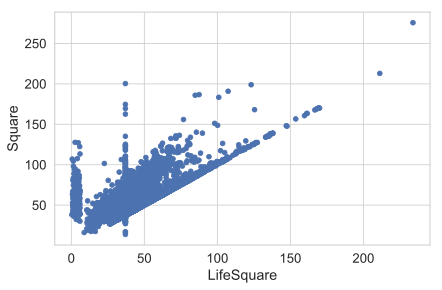

In [117]:
plt.scatter(df_train['LifeSquare'], df_train['Square']);    
plt.xlabel('LifeSquare')
plt.ylabel('Square')
plt.show()

### Построение новых признаков

#### RoomSquare (площадь комнаты)

In [118]:
df_train['RoomSquare'] = df_train['Square'] / df_train['Rooms']
df_test['RoomSquare'] = df_test['Square'] / df_test['Rooms']

#### PriceOneRoom (стоимость одной комнаты)

In [119]:
df_train['PriceOneRoom'] = df_train['Price'] / df_train['Rooms']
df_train['PriceOneRoom'].describe()

count    10,000.00
mean    124,237.47
std      50,731.16
min      20,585.69
25%      89,443.65
50%     114,961.11
75%     152,997.53
max     594,565.30
Name: PriceOneRoom, dtype: float64

#### PriceOneRoomByDistrict (стоимость одной комнаты по определенному району)

In [120]:
price_by_district = df_train.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

price_by_district.head()

DistrictId  PriceOneRoomByDistrict
0          0              108,490.12
1          1              106,080.90
2         10              113,675.12
3        100              146,060.10
4        101              104,499.16

### Отбор признаков

In [121]:
df_train.to_csv('train_prepared.csv')
df_test.to_csv('test_prepared.csv')
ftest = df_test.columns
ftest.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'RoomSquare']

In [122]:
feature_names = df_train.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'RoomSquare',
 'PriceOneRoom']

In [123]:
target_name = ['Price']
feature_names = [
#             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#             'Ecology_2',
#             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
             'Helthcare_2',
             'Shops_1',
#             'Shops_2',
#             'Price',
#             'PriceOneRoom',
#              'PriceOneRoomByDistrict',
             'RoomSquare'
                ]

### RandomForestRegressor

In [124]:
X = df_train[feature_names]
y = df_train[target_name]

X_test = df_test[feature_names]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X.describe()

Rooms    Square  KitchenSquare     Floor  HouseFloor  HouseYear  \
count 10,000.00 10,000.00      10,000.00 10,000.00   10,000.00  10,000.00   
mean       1.89     56.22           5.86      8.53       12.61   1,984.87   
std        0.81     19.06           5.07      5.24        6.78      18.41   
min        1.00     13.78           0.00      1.00        0.00   1,910.00   
25%        1.00     41.79           1.00      4.00        9.00   1,974.00   
50%        2.00     52.51           6.00      7.00       13.00   1,977.00   
75%        2.00     65.89           9.00     12.00       17.00   2,001.00   
max        6.00    275.65         123.00     42.00      117.00   2,020.00   

       Ecology_1  Social_1  Social_2  Social_3  Helthcare_2   Shops_1  \
count  10,000.00 10,000.00 10,000.00 10,000.00    10,000.00 10,000.00   
mean        0.12     24.69  5,352.16      8.04         1.32      4.23   
std         0.12     17.53  4,006.80     23.83         1.49      4.81   
min         0.00      0.00    168.00      0.00         0.00      0.00   
25%         0.02      6.00  1,564.00      0.00         0.00      1.00   
50%         0.08     25.00  5,285.00      2.00         1.00      3.00   
75%         0.20     36.00  7,227.00      5.00         2.00      6.00   
max         0.52     74.00 19,083.00    141.00         6.00     23.00   

       RoomSquare  
count   10,000.00  
mean        32.47  
std         10.01  
min          4.59  
25%         25.61  
50%         30.83  
75%         39.03  
max        174.65

In [125]:
scaler = StandardScaler()

In [126]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=feature_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [127]:
model = RandomForestRegressor(n_estimators=1000, max_depth=19, max_features=7, random_state=42)

In [128]:
model.fit(X_train_scaled, y_train)
    
y_train_pred = model.predict(X_train_scaled) 
y_test_pred = model.predict(X_valid_scaled)
    
r2_train = r2_score(y_train, y_train_pred)
print(f'r2_train = {r2_train}')
    
r2_test = r2_score(y_valid, y_test_pred)
print(f'r2_test = {r2_test}')

r2_train = 0.959011526905169
r2_test = 0.7280416940626728


In [129]:
y_pred = model.predict(X_test_scaled)

preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

Id      Price
0    725 163,533.78
1  15856 220,721.80
2   5480 173,583.50
3  15664 348,629.94
4  14275 135,043.81

In [130]:
preds.to_csv('RIdrisov_predictions.csv', index=False)